# Redes Neurais e Aprendizado Profundo
SCC0270 - 2/2022


## Trabalho 1 - Redes Densas e Convolucionais

NOME: Gianluca Capezzuto Sardinha

NUSP: 11876933

NOME: Pedro Cavallini

NUSP: 11801007

Neste trabalho você deverá implementar duas redes neurais usando Pytorch, uma utilizando camadas densas e outra utilizando camadas convolucionais. Será utilizado o dataset Fashion MNIST.

### Instruções:

- Preencha o nome e o número USP da dupla na célula acima;
- Renomeie o notebook, inserindo o número USP de cada um da dupla, conforme o exemplo: "SCC0270-T1-1234567-7654321";
- Neste notebook, você irá encontrar 5 exercícios, cada um deles valendo uma certa quantidade de pontos. A conclusão de todos os exercícios com sucesso valerá nota 10;
- Responda cada exercício inserindo o código adequado para cada função.
- Envie o notebook inteiro como entrega do exercício.
- Certifique-se de que os códigos executam corretamente, uma vez que a nota só será atribuída caso seja possível executar o código, e ele esteja correto.
- Fraudes ou plágio implica em nota zero e possíveis medidas administrativas.


### Objetivos:

- Compreender como o aprendizado de máquina consegue resolver problemas que métodos tradicionais de programação não conseguem
- Aprender sobre o dataset público Fashion MNIST
- Observar as diferenças do uso de camadas densas e convolucionais

### Imports

In [1]:
from torchvision import datasets, transforms, utils # Pacote de datasets populares, arquiteturas e modelos de aprendizado profundo

# Importações de algumas bibliotecas úteis para a construção da rede
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# Bibliotecas adicionais 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Selecionar GPU caso disponível
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


/home/gian/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


### Dataset Fashion-MNIST

### Dados, Anotações e Subsets

- `train_set`: Imagens usadas para treinar a rede neural. Contém anotações corretas para cada imagem de `train_set`, usado para avaliar as predições do modelo durante a fase de treinamento.
- `test_set`: Imagens usadas para avaliar o desempenho do modelo, uma vez que ele já foi treinado. Contém anotações corretas para cada imagem de `test_set`, usado para avaliar as predições do modelo durante a fase de validação


### Importar dados para a memória

In [3]:
# Fazer o download dos dados de treinamento e teste
train_set = datasets.FashionMNIST(
    "./data", 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor()])
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

test_set = datasets.FashionMNIST(
    "./data", 
    download=True, 
    train=False, 
    transform=transforms.Compose([transforms.ToTensor()])
) 
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

### Explorando o dataset

In [4]:
# Tamanho do dataset
len(train_set)

60000

In [5]:
# Vamos observar o que é cada loader
example = next(iter(train_loader))
example[0].size()

torch.Size([100, 1, 28, 28])

9


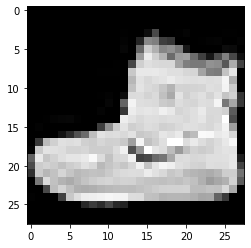

In [6]:
# Uma imagem do train_set com sua respectiva label
img, label = next(iter(train_set))
plt.imshow(img.squeeze(), cmap="gray")
print(label)

In [7]:
# Função de ajuda para ler o que significa cada label
def convert_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat", 
        5: "Sandal", 
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    
    if type(label) == torch.Tensor:
        input = label.item()  
    else:
        input = label

    return output_mapping[input]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

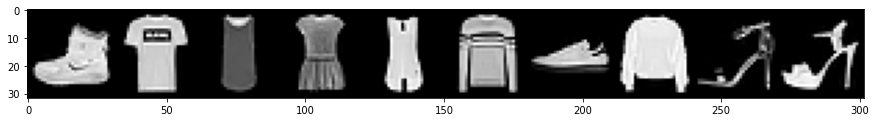

In [8]:
# Vamos observar algumas imagens do Fashion MNIST
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(convert_label(label), end=", ")

### Exercício 1 (3 pontos)

**Exercício**: Neste trabalho, será necessário implementar duas arquiteturas distintas de redes neurais. Uma vez que elas estejam implementadas, será necessário executar o laço (loop) de treinamento dos modelos por diversas épocas. Para isso, nesse primeiro exercício, crie uma função genérica, capaz de receber um modelo Pytorch e executar os passos básicos de propagação, cálculo do erro, retropropagação e atualização dos pesos. Essa função será utilizada nos exercícios seguintes para treinar os modelos por você implementados. Implemente o laço de treinamento de um modelo por num_epochs.

**Instruções**:
- Implemente os passos de propagação (forward)
- Realize o cálculo do erro usando um critério genérico fornecido pela assinatura da função
- Inicialize os gradientes a zero
- Implemente o passo de retropropagação do erro (backpropagation)
- Faça um passo de otimização
- DICA: como essas linhas estão englobadas em uma função, utilize os argumentos da função fit(...), de forma genérica


In [9]:
def fit(model, criterion, optimizer, train_loader, test_loader, num_epochs=10):
    model.to(device)
    
    train_losses = [] # Lista para armazenar as perdas de treino
    test_losses = [] # Lista para armazenar as perdas de teste
    
    accuracy_list = [] # Lista para armazenar a acurácia do modelo

    predictions_list = [] # Lista para armazenar as predições do modelo
    labels_list = [] # Lista para armazenar os rotulos do modelo

    # 'for' passando por todas as épocas do modelo 
    for epoch in range(num_epochs):
        running_loss = 0 # Setando a perda para 0 a cada época

        # 'for' passando por cada imagem e cada label no train_loader
        for images, labels in train_loader:
            # Transferindo as imagens e as labels para GPU
            images, labels = images.to(device), labels.to(device)

            ### INÍCIO DO CÓDIGO ### (≈ 5 linhas)
            
            outputs = model(images) # Passando as imagens pela rede
            loss = criterion(outputs, labels) # Calculando a perda com algum dos critérios (MSE, CrossEntropy, etc)
            optimizer.zero_grad() # Zerando o buffer dos gradientes
            loss.backward() # Fazendo o backpropagation
            optimizer.step() # Atualizando os pesos com o otimizador
            
            ### FIM DO CÓDIGO ###

            running_loss += loss.item() # Somando a perda de cada batch

        else:
        # Testando o modelo

            with torch.no_grad():
                # Desabilitando o cálculo de gradientes para acelerar o processo
                model.eval()

                total = 0
                test_loss = 0
                correct = 0

                # 'for' passando por cada imagem e cada label no test_loader
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    labels_list.append(labels)
                    total += len(labels)
                    
                    ### INÍCIO DO CÓDIGO ### (≈ 1 linha)

                    outputs = model(images) # Passando as imagens pela rede treinada
                    
                    ### FIM DO CÓDIGO ###
                    
                    predictions = torch.max(outputs, 1)[1].to(device) # Retorna o valor máximo de todos os elementos do tensor
                    predictions_list.append(predictions)
                    correct += (predictions == labels).sum() # Contando quantas predições foram corretas

                    test_loss += criterion(outputs, labels).item() # Somando a perda de teste
                test_losses.append(test_loss/len(test_loader))

                accuracy = correct * 100 / total # Verficando a acurácia do modelo
                accuracy_list.append(accuracy.item())
        
            # Setando o modelo para treinamento
            model.train()
        
        train_losses.append(running_loss/len(train_loader))

        print(f'Epoch {epoch+1}/{num_epochs} .. Train Loss: {train_losses[-1]:.5f} .. Test Loss: {test_losses[-1]:.5f} .. Test Accuracy: {accuracy_list[-1]:.3f}%')

            
    results = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'accuracy_list': accuracy_list
    }
    
    return results

### Exercício 2 - Camadas Densas (2 pontos)

**Exercício 2.A**: Implemente uma rede neural, usando camadas densas (fully connected), capaz de classificar as imagens do dataset Fashion MNIST. Descreva e justifique a escolha dos parâmetros e das camadas.

**Instruções**:
- Inicialize a superclasse
- Crie o projeto da rede neural usando camadas densas
- Implemente o passo de propagação
- Insira uma célula de texto, ou comentários ao longo do código com a justificativa

In [10]:
class NetworkDense(nn.Module):

    def __init__(self):
        
        ### INÍCIO DO CÓDIGO ### (≈ 5 linhas)
        super(NetworkDense, self).__init__() # Inicialização da classe pai
        # Cria o projeto da rede neural     
        self.fc1 = nn.Linear(784, 32) # Camada densa de entrada
        self.fc2 = nn.Linear(32, 10) # Camada densa de saída
        ### FIM DO CÓDIGO ###

    def forward(self, x):
        
        ### INÍCIO DO CÓDIGO ### (≈ 5 linhas)
        x = torch.flatten(x, 1) # Achatamento da imagem - Convertendo de 2D para um vetor de 784 valores de pixel
        x = F.relu(self.fc1(x)) # Função de ativação
        x = self.fc2(x) # Saída
        ### FIM DO CÓDIGO ###
        
        return x


In [11]:
# Justifique a escolha da arquitetura

**Exercício 2.B**: Utilizando a classe `NetworkDense` implementada anteriormente, inicialize o modelo, defina uma função para loss, o otimizador, e a learning rate desejados. Depois, treine o modelo por algumas épocas.

In [12]:
### INÍCIO DO CÓDIGO ### (≈ 4 linhas)
model_dense = NetworkDense()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model_dense.parameters(), lr=learning_rate)
### FIM DO CÓDIGO ###

print(model_dense)

NetworkDense(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [13]:
### INÍCIO DO CÓDIGO ### (≈ 1 linha)
den_results = fit(model_dense, criterion, optimizer, train_loader, test_loader)
### FIM DO CÓDIGO ###

Epoch 1/10 .. Train Loss: 0.65415 .. Test Loss: 0.50330 .. Test Accuracy: 82.420%
Epoch 2/10 .. Train Loss: 0.45385 .. Test Loss: 0.45994 .. Test Accuracy: 83.830%
Epoch 3/10 .. Train Loss: 0.41832 .. Test Loss: 0.43866 .. Test Accuracy: 84.440%
Epoch 4/10 .. Train Loss: 0.39743 .. Test Loss: 0.42671 .. Test Accuracy: 84.830%
Epoch 5/10 .. Train Loss: 0.38266 .. Test Loss: 0.41839 .. Test Accuracy: 84.950%
Epoch 6/10 .. Train Loss: 0.37079 .. Test Loss: 0.41168 .. Test Accuracy: 85.320%
Epoch 7/10 .. Train Loss: 0.36035 .. Test Loss: 0.40484 .. Test Accuracy: 85.490%
Epoch 8/10 .. Train Loss: 0.35092 .. Test Loss: 0.40071 .. Test Accuracy: 85.710%
Epoch 9/10 .. Train Loss: 0.34288 .. Test Loss: 0.39730 .. Test Accuracy: 85.810%
Epoch 10/10 .. Train Loss: 0.33569 .. Test Loss: 0.39314 .. Test Accuracy: 85.880%


### Exercício 3  - Camadas Convolucionais (2 pontos)

**Exercício 3.A**: Implemente uma rede neural, usando camadas convolucionais (Conv2d), capaz de classificar as imagens do dataset Fashion MNIST. Descreva e justifique a escolha dos parâmetros e das camadas.

**Instruções**:
- Inicialize a superclasse
- Crie o projeto da rede neural usando camadas convolucionais
- Implemente o passo de propagação
- Insira uma célula de texto, ou comentários ao longo do código com a justificativa

In [46]:
class NetworkCNN(nn.Module):
    
    def __init__(self):
        ### INÍCIO DO CÓDIGO ### 
        super(NetworkCNN, self).__init__() # Inicialização da classe pai
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 2), # Camada de convolução
            nn.ReLU(), # Função de ativação
            nn.MaxPool2d(2, 2) # Camada de pooling
            )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2), # Camada de convolução     
            nn.ReLU(), # Função de ativação
            nn.MaxPool2d(2), # Camada de pooling
        )
        self.fc1 = nn.Linear(7*7*32, 10) # Camada densa de saída
        ### FIM DO CÓDIGO ###
        
        
    def forward(self, x):
        
        ### INÍCIO DO CÓDIGO ### 
        x = self.conv1(x) # Passando pela primeira camada de convolução
        x = self.conv2(x) # Passando pela segunda camada de convolução
        x = x.view(-1, 7*7*32) # Achatamento da imagem - Convertendo de 2D para um vetor de 784 valores de pixel
        x = self.fc1(x) # Achatamento da imagem - Convertendo de
        ### FIM DO CÓDIGO ###
        
        return x

In [33]:
# Justifique a escolha da arquitetura

**Exercício 3.B**: Utilizando a classe `NetworkCNN` implementada anteriormente, inicialize o modelo, defina uma função para loss, o otimizador, e a learning rate desejados. Depois, treine o modelo por algumas épocas.

In [47]:
### INÍCIO DO CÓDIGO ### (≈ 4 linhas)
model_cnn = NetworkCNN() # Instanciando a rede neural
criterion = nn.CrossEntropyLoss() # Definindo a função de perda
learning_rate = 0.001 # Taxa de aprendizado
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate) # Definindo o otimizador
### FIM DO CÓDIGO ###

print(model_cnn)

NetworkCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)


In [48]:
### INÍCIO DO CÓDIGO ### (≈ 1 linha)
cnn_results = fit(model_cnn, criterion, optimizer, train_loader, test_loader)
### FIM DO CÓDIGO ###

Epoch 1/10 .. Train Loss: 0.54289 .. Test Loss: 0.39464 .. Test Accuracy: 85.820%
Epoch 2/10 .. Train Loss: 0.34820 .. Test Loss: 0.34319 .. Test Accuracy: 87.640%
Epoch 3/10 .. Train Loss: 0.30368 .. Test Loss: 0.31551 .. Test Accuracy: 88.620%
Epoch 4/10 .. Train Loss: 0.27569 .. Test Loss: 0.29667 .. Test Accuracy: 89.370%
Epoch 5/10 .. Train Loss: 0.25481 .. Test Loss: 0.28591 .. Test Accuracy: 89.700%
Epoch 6/10 .. Train Loss: 0.23784 .. Test Loss: 0.27731 .. Test Accuracy: 90.010%
Epoch 7/10 .. Train Loss: 0.22356 .. Test Loss: 0.27231 .. Test Accuracy: 90.240%
Epoch 8/10 .. Train Loss: 0.21126 .. Test Loss: 0.26737 .. Test Accuracy: 90.500%
Epoch 9/10 .. Train Loss: 0.20007 .. Test Loss: 0.26641 .. Test Accuracy: 90.620%
Epoch 10/10 .. Train Loss: 0.18996 .. Test Loss: 0.26756 .. Test Accuracy: 90.430%


### Exercício 4  - Quantidade de parâmetros treináveis (1 ponto)

**Exercício**: Quantos parâmetros treináveis cada um dos modelos desenvolvidos possui? Justifique. Informe os valores para `model_dense` e `model_cnn`.

In [49]:
# Para fazer o cálculo dos parâmetros será feito tanto de forma empírica quanto analítica:
parameters_fc = 0
parameters_cnn = 0 

for param in model_dense.parameters():
    parameters_fc += param.numel()
for param in model_cnn.parameters():
    parameters_cnn += param.numel()

print(f'Número de parâmetros para camadas densas: {parameters_fc}')
print(f'Número de parâmetros para camadas densas: {parameters_cnn}')

Número de parâmetros para camadas densas: 25450
Número de parâmetros para camadas densas: 28682


### Exercício 5 - Comparação de Resultados (2 pontos)

**Exercício**: Compare as métricas de acurácia dos dois modelos desenvolvidos. Qual dos dois obteve melhores resultados?  Por quê? Qual característica das redes que justificam seu desempenho?

Utilize o gráfico para auxiliar na análise. Insira uma célula de texto com a sua resposta

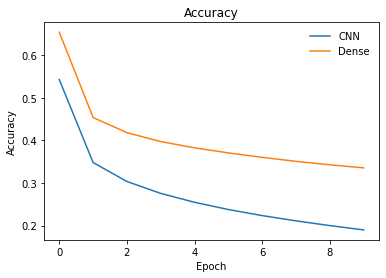

In [50]:
### INÍCIO DO CÓDIGO ### (≈ 2 linhas)
plt.plot(cnn_results['train_losses'], label='CNN')
plt.plot(den_results['train_losses'], label='Dense')
### FIM DO CÓDIGO ###

plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.show()

(Escreva sua resposta)

### Indo além... - Comparação de Resultados (sem ponto)

É possível plotar o gráfico de loss do treino e da validação para cada um dos modelos. Observe como os erros se comportam de maneira diferente para cada um dos subsets.

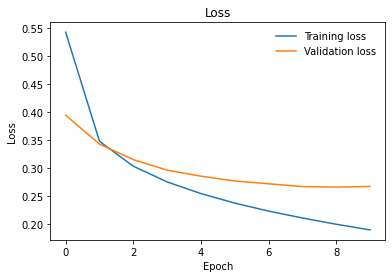

In [51]:
plt.plot(cnn_results['train_losses'], label='Training loss')
plt.plot(cnn_results['test_losses'], label='Validation loss')

plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

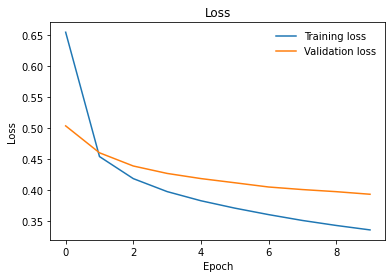

In [52]:
plt.plot(den_results['train_losses'], label='Training loss')
plt.plot(den_results['test_losses'], label='Validation loss')

plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()